# Summary of Best Model (Xception)

This notebook looks deeper into the best performing model from the previous notebooks.

In [1]:
import os
import pandas as pd
import shutil
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import (load_img, 
                                                  img_to_array, 
                                                  ImageDataGenerator)
from tensorflow.keras.utils import plot_model

from utils import log_runs, visualize_log, plot_accuracy

# Metrics
## Test Accuracy all models

In [2]:
# get log names of for al models
log_names = [x for x in os.listdir('logs') if x.startswith('model_log')]
log_names

['model_log_xcept', 'model_log_vgg16', 'model_log_cnn', 'model_log_mlp']

In [3]:
# concat the logs
logs = []
for log_name in log_names:
    logs.append(pd.read_pickle(os.path.join('logs', log_name)))

logs = pd.concat(logs)
logs = logs.sort_values('test_accuracy', ascending=False)
logs.head()

,name,type,runtime,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
xcept_1616000165_9e799a90,xcept-zoom,xcept,00:22:10.472872,0.251571,0.943548,"[0.9853468537330627, 0.5710867047309875, 0.474...","[0.6659330725669861, 0.8142605423927307, 0.841...","[0.6369487047195435, 0.5299108624458313, 0.518...","[0.8091602921485901, 0.8320610523223877, 0.832..."
xcept_1616000143_ab0cf355,xcept-shift,xcept,00:12:43.548203,0.266454,0.935484,"[0.9597858786582947, 0.5754048228263855, 0.477...","[0.6892605423927307, 0.8028169274330139, 0.841...","[0.6559360027313232, 0.5588362216949463, 0.526...","[0.7633587718009949, 0.8244274854660034, 0.824..."
xcept_1616000158_70963c53,xcept-rotation,xcept,00:12:24.404457,0.261420,0.935484,"[0.9399111270904541, 0.5682889223098755, 0.480...","[0.6844190359115601, 0.8089788556098938, 0.841...","[0.6247003078460693, 0.5532976984977722, 0.506...","[0.8091602921485901, 0.847328245639801, 0.8396..."
xcept_1616000161_d0f2d641,xcept-brightness,xcept,00:11:18.432261,0.272397,0.935484,"[0.9299495816230774, 0.5391831994056702, 0.448...","[0.685299277305603, 0.8257042169570923, 0.8560...","[0.630313515663147, 0.5592529773712158, 0.5037...","[0.8015267252922058, 0.8396946787834167, 0.847..."
xcept_1615998062_8d26c458,xcept-adam,xcept,00:11:54.373864,0.272281,0.927419,"[0.928770899772644, 0.5393918752670288, 0.4478...","[0.7064260840415955, 0.8182218074798584, 0.851...","[0.6289923191070557, 0.5730010271072388, 0.498...","[0.7862595319747925, 0.8015267252922058, 0.839..."


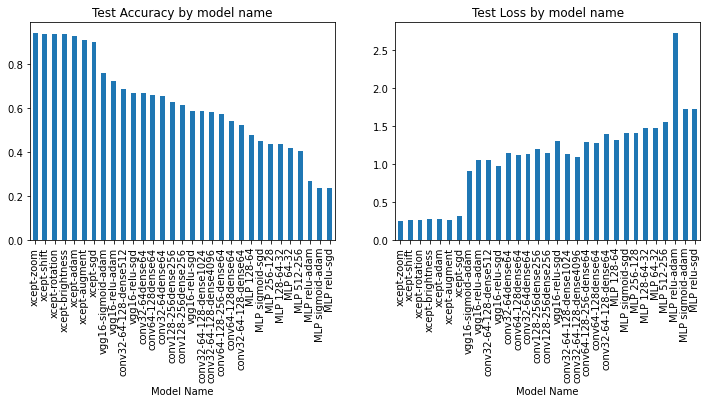

In [4]:
# plot accuracy
plot_accuracy(logs)

## Best Model: Xception

### Model Summary
From the Xception notebook we remember that while the xcept-zoom model had the highest test accuracy, th except-augment model with an array of image data augmentations including shift, rotation, brightness, and zoom showed fewer signs of over fitting.  As a result we will take that model as our final "best" model.

In [5]:
# load the best model.
best_model_id = logs[logs['name'] == 'xcept-augment'].index[-1]
model = models.load_model(os.path.join('models', best_model_id + '.h5'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 20,873,774
Trainable params: 12,294
Non-trainable params: 20,861,480
_________________________________________________________________


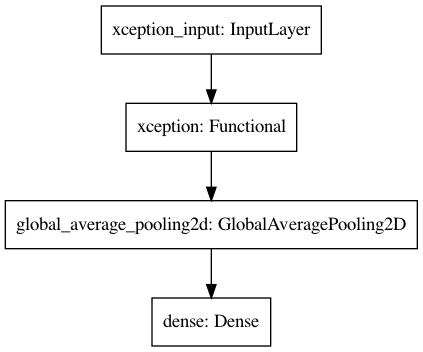

In [7]:
# visualize the model structure
plot_model(model)

In [8]:
# view the summary of the nested xception model
model.layers[0].summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 121, 121, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 121, 121, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 121, 121, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Confusion Matrix

In [9]:
from tensorflow.math import confusion_matrix

# Create test ImageDataGenerator to pull 8 images at a time
test_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory('data/split/test',
                                             target_size = (244, 244),
                                             batch_size = 124,
                                             shuffle=False)

Found 124 images belonging to 6 classes.


In [10]:
test_generator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5], dtype=int32)

In [11]:
# create a reverse map for getting category names
class_map = {v:k for k, v in test_generator.class_indices.items()}
class_map

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [12]:
# generate predictions
preds = model.predict(test_generator)
preds = [np.argmax(x) for x in preds]

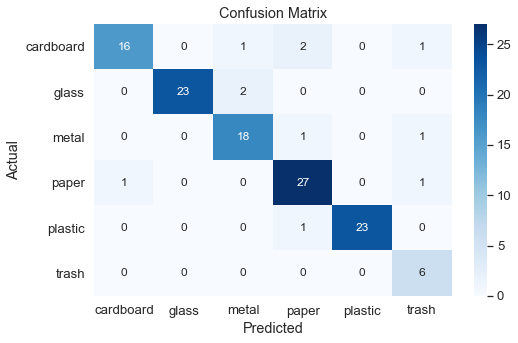

In [13]:
# generate confusion matrix from tensorflow
conf_matrix = confusion_matrix(
    test_generator.labels, preds).numpy()

# get label names
labels = [class_map[x] for x in [0,1,2,3,4,5]]

# create a dataframe with column names
df_cm = pd.DataFrame(conf_matrix,
                     columns=labels,
                     index = labels)

# set axis names
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

#Plot the fiture
plt.figure(figsize = (8,5))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 12})
plt.title('Confusion Matrix');

### Classification Report

In [14]:
from sklearn.metrics import classification_report

# get named y_true and y_pred
y_true = [class_map[x] for x in test_generator.labels]
y_pred = [class_map[x] for x in preds]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

   cardboard       0.94      0.80      0.86        20
       glass       1.00      0.92      0.96        25
       metal       0.86      0.90      0.88        20
       paper       0.87      0.93      0.90        29
     plastic       1.00      0.96      0.98        24
       trash       0.67      1.00      0.80         6

    accuracy                           0.91       124
   macro avg       0.89      0.92      0.90       124
weighted avg       0.92      0.91      0.91       124



# Predictions
Visualize images with their predicted values

In [15]:
# Create test ImageDataGenerator to pull 8 images at a time
test_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory('data/split/test',
                                             target_size = (244, 244),
                                             batch_size = 8)

Found 124 images belonging to 6 classes.


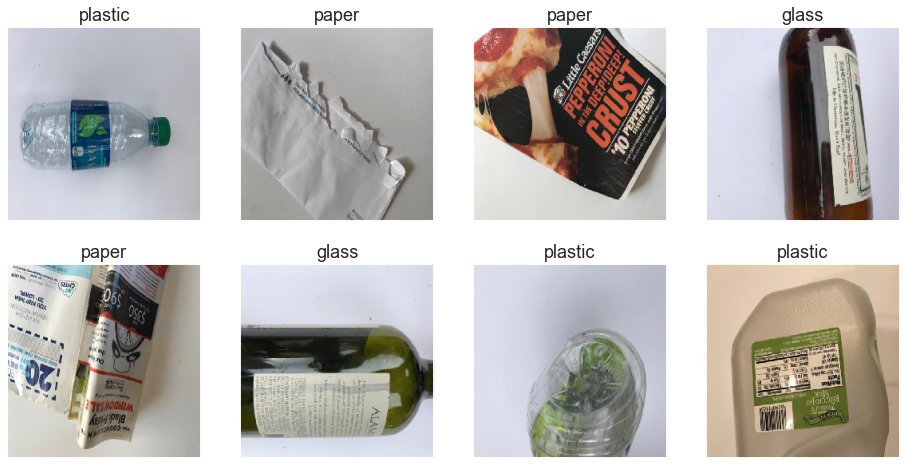

In [16]:
# Get a batch of images
img, label = next(test_generator)

# get predictions
preds = [x.argmax() for x in model.predict(img)]

# plot images
with sns.plotting_context('talk'):
    fig, axs = plt.subplots(2,4, figsize=(16,8))
    axs = np.array(axs).flatten()
    
    # loop through images and show them with thier predicted label
    for i, ax in enumerate(axs):
        ax.imshow(img[i])
        ax.set_title(class_map[preds[i]])
        ax.set_xticks([])
        ax.set_yticks([])

# Visualize filters
Here we will grab the output of the Conv2D layers to visualize the filter maps.

In [17]:
# pull out the exception model
xception = model.layers[0]

# get the conv2d layers
conv_layers = []
for i in range(0, len(xception.layers)):
    if xception.layers[i].name.startswith('conv2d'):
        conv_layers.append(i)
conv_layers

[12, 22, 32, 122]

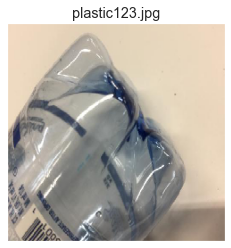

In [18]:
# choose a random category from the test set
categories = os.listdir('data/split/test')
cat = np.random.choice(categories)

# choose a random image in that category
file_name = np.random.choice(os.listdir(os.path.join('data/split/test',cat)))

# load and display the image
img_orig = load_img(os.path.join('data/split/test',cat,file_name), 
               target_size=(244, 244))
plt.imshow(img_orig)
plt.title(file_name)
plt.xticks([])
plt.yticks([]);

0 12
1 22
2 32
3 122


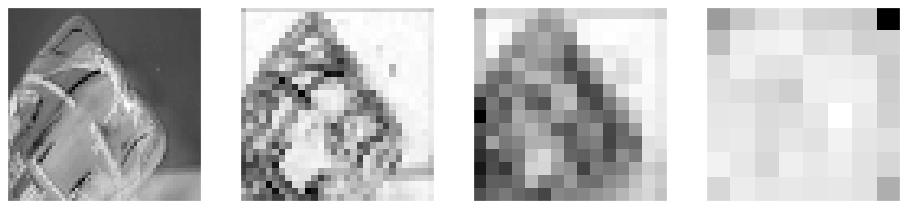

In [19]:
# convert the image to an array
img = img_to_array(img_orig)

# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)

# scaele the values
img = img/255.

fig, axs = plt.subplots(1,4, figsize=(16,8))
axs = np.array(axs).flatten()

for i, val in enumerate(conv_layers):
    print(i, val)
    
    print(xception.layers[12])
    # redefine model to output right after the first hidden layer
    xception2 = models.Model(inputs=xception.inputs, 
                            outputs=xception.layers[val].output)
    
    # get feature map for first hidden layer
    feature_maps = xception2.predict(img)
    # plot all 64 maps in an 8x8 squares

    axs[i].imshow(feature_maps[0, :, :, 20], cmap='gray')

    # remove the ticks
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Recommendations for improvement

This project could be improved by:

* Adding more images in more contexts.  This would likely improve the ability of the model to classify images.
* Review the categories with a recycling specialist to ensure these categories are the most useful.

# Future work

* Test other methodologies including whether classifying whether an item is recyclable before classifying the recycling type.
* Test whether method of image recognition can differentiate between different kinds of plastics.
* If this does prove effective, consider releasing a phone app
* If this does prove effective, consider integrating into recycling facilities

# Conclusion

The best performing model in this set of tests was the pre-trained Xception model.  Further improvement would likely be possible by fine tuning some of the layers of the original Xception model with a very small learning rate.